In [3]:
import sys
import os
IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR) 


from imatools.common import ioutils as iou
from imatools.common import vtktools as vtku

import pandas as pd 
import numpy as np


In [4]:

# Locations of hard drive based on platform
dirdic={'macOS'   : '/Volumes/sandisk', 
        'Linux'   : '/media/jsl19/sandisk' , 
        'Windows' : 'D:/'}

p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence.csv'

df = pd.read_csv(iou.fullfile(p2f, 'local',name), skipinitialspace=True)
df_stats = pd.read_csv(iou.fullfile(p2f, 'results_local', 'stats.csv'), skipinitialspace=True)

In [5]:
def get_data_from_vtk_path(path, type='cell') : 
    msh = vtku.readVtk(path)
    if type=='cell' : 
        dat = vtku.convertCellDataToNpArray(msh, 'scalars')
    else : # type=='point'
        dat = vtku.convertPointDataToNpArray(msh, 'scalars')
    return dat 

CX = ['2', '5', '6', '8', '9', '11', '12', '13', '15', '16', '17', '18', '19', '21', '22', '24', '26', '7', '10', '14', '20', '23', '25']

xnav = lambda x : 'LGE_{}NAV'.format(x)
dname = 'Normalised_IIR_MaxScar-single-voxel.vtk'
iname = 'Scalars_i_on_d.vtk'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstat

# cx = 0
fig, ax = plt.subplots(4, 6, sharex=True, sharey=True,squeeze=True)
fig.set_figwidth(18)
fig.set_figheight(12)

sns.set_palette('colorblind')

corrs = np.zeros(len(CX))

for cx in range(len(CX)) : 
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname))
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname))

    df_test = pd.DataFrame({
        'scalars': ddat.tolist() + idat.tolist(), 
        'nav': ['dNAV'] * len(ddat) + ['iNAV']*len(idat)
        })

    subs = np.unravel_index(cx, (4,6))
    corrs[cx] = sstat.pearsonr(ddat, idat).statistic

    ax[subs].set_title('Case {} (r={:.2f})'.format(CX[cx], corrs[cx]))
    sns.histplot(ax=ax[subs], data=df_test, x='scalars', hue='nav', 
                element='step', bins=50, multiple='dodge', stat='count', 
                binrange=(0, 2.5))


# plt.savefig(iou.fullfile(iou.fullfile(p2f, 'local', 'scalar_comparison.eps')))



In [ ]:
case_mean_diff = np.zeros(len(CX))
for cx in range(len(CX)):
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname))
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname))

    case_mean_diff[cx] = np.mean(np.subtract(ddat, idat))


sns.boxplot(y=case_mean_diff)
print(sstat.ttest_1samp(a=case_mean_diff, popmean=0))

In [ ]:
# import scipy.stats as sstat
# help(sstat.ttest_1samp)

def print_stats(arr) :
    print('{} +/- {}'.format(np.mean(arr), np.std(arr)))

print_stats(case_mean_diff)
print_stats(corrs)
print(iou.get_boxplot_values(corrs))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
print('')
# sns.histplot(x=case_mean_diff, bins=20)

In [ ]:
# 
#print('{:.2f} +/- {:.2f}'.format(np.nanmean(corrs),np.nanstd(corrs)))

np.sort(CX)

In [ ]:
# import matplotlib.pyplot as plt

# df_stats['LGE_TYPE']=='iNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='or')
# else :
#     sns.scatterplot(data=df_stats, x='CASE', y='FIB_SCORE ', hue='LGE_TYPE')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot(x,y)


In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')

sns.boxplot(ax=ax[0], x=df['th_inav'], y=(df['fibrosis_d']-df['fibrosis_i'])
            ** 2, order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265], 
            whis=1)
sns.scatterplot(ax=ax[1], data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot()

ax[0].set_xlabel('iNAV IIR Threshold')
ax[0].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('dNAV Fibrosis %')
ax[1].set_ylabel('iNAV Fibrosis %')

# sns.lmplot( data=df, x='fibrosis_d', y='fibrosis_i', col='th_inav', col_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

In [ ]:

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df, 
    x='perf_name', y='performance', hue='th_inav', whis=1,
    hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [ ]:
metric_name = 'dice'
th = [1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265]

print(metric_name)
for threshold in th :
    # threshold = 1.1205
    metric = df['performance']
    thresh = df['th_inav']

    metric = metric[df['perf_name']==metric_name]
    thresh = thresh[df['perf_name']==metric_name]

    metric = metric[thresh==threshold]

    print('{:.3f} (+/-{:.3f})'.format(np.mean(metric), np.std(metric)))


# Point analysis 

+ Load a case 
+ Move cell data to point data 
+ Explore

**Sanity check**: check that the correct data are being retrieved - _PASSED_

Compare the point data coming out of the mesh to the point data after converting cell to point.

In [ ]:
cx = 2

dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
ipath = iou.fullfile(p2f, 'local', CX[cx], iname) 

dmsh = vtku.readVtk(dpath)
imsh = vtku.readVtk(ipath)
ddat = vtku.convertPointDataToNpArray(dmsh, 'scalars')
idat = vtku.convertPointDataToNpArray(imsh, 'scalars')

dmsh_pts = vtku.set_cell_to_point_data(dmsh, 'scalars')
imsh_pts = vtku.set_cell_to_point_data(imsh, 'scalars')
ddat_pts = vtku.convertPointDataToNpArray(dmsh_pts, 'scalars')
idat_pts = vtku.convertPointDataToNpArray(imsh_pts, 'scalars')

print('len idat: {}, len idat_pts: {}'.format(len(idat), len(idat_pts)))
print('idat - idat_pts : {}'.format(np.mean(np.subtract(idat, idat_pts))))
# ddat = get_data_from_vtk_path(dpath)
# idat = get_data_from_vtk_path(ipath)


Create all point-based `scalars_i_on_d` files. 

> NOTE: dNAV normalised scalars already have the point data saved in them.

In [ ]:
# dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
# cx = 2
def fileparts(pth):
    directory = os.path.dirname(pth)
    fname_ext = os.path.basename(pth)
    aux = os.path.splitext(fname_ext)
    fname = aux[0]
    ext = aux[1]

    return directory, fname, ext


for cx in range(len(CX)) : 
    
    ipath = iou.fullfile(p2f, 'local', CX[cx], iname)
    imsh = vtku.readVtk(ipath)
    imsh_pts = vtku.set_cell_to_point_data(imsh, 'scalars')

    di, fn, xt = fileparts(ipath)
    iname_pts = fn + "_pts"
    vtku.writeVtk(imsh_pts, di, iname_pts)


+ We ran the `10_project_inav_on_dnav.sh` script, commenting the projection (as we do not need to create the `scalars_i_on_d` files). 
+ Once done, we rerun some of the calculations done before
+ see below

# Sweep thresholds - get fibrosis scores 

First get the point fibrosis scores from all dnavs

In [4]:
import numpy as np
dname = 'Normalised_IIR_MaxScar-single-voxel.vtk'
iname_pts = 'Scalars_i_on_d_pts.vtk'

sweep = np.arange(0.7, 1.59, 0.01)
len_sweep = len(sweep)

args_min = np.zeros((len(sweep), 1), dtype=int)

dfib_scores = np.zeros((len(CX), 1))
ifib_best_scores = np.zeros_like(dfib_scores)
ifib_best_thresholds = np.zeros_like(dfib_scores)
ifib_scores_1d2 = np.zeros_like(ifib_best_scores)

sq_err_1d2 = np.zeros_like(dfib_scores)
sq_err_best = np.zeros_like(dfib_scores)
for cx in range(len(CX)):
    dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
    dmsh = vtku.readVtk(dpath)

    dfib_scores[cx] = vtku.fibrosis_score_point(dmsh, 1.2)

    ipath_pts = iou.fullfile(p2f, 'local', CX[cx], iname_pts)
    imsh_pts = vtku.readVtk(ipath_pts)

    sweep_scores = np.zeros((len_sweep, 1))
    for ix in range(len_sweep):
        sweep_scores[ix] = vtku.fibrosis_score_point(imsh_pts, sweep[ix])

    sq_err = np.power(sweep_scores-dfib_scores[cx], 2)
    args_min[cx] = np.argmin(sq_err)
    
    ifib_scores_1d2[cx] = sweep_scores[50] 
    sq_err_1d2[cx] = sq_err[50]

    ifib_best_thresholds[cx] = sweep[args_min[cx]]
    ifib_best_scores[cx] = sweep_scores[args_min[cx]]
    sq_err_best[cx] = sq_err[args_min[cx]]


Wilcoxon test on new fibrosis values

In [12]:
import scipy.stats as sstat
print('Ranksum')
print(sstat.ranksums(x=dfib_scores, y=ifib_scores_1d2))
print("Ttest")
print(sstat.ttest_1samp(a=dfib_scores-ifib_scores_1d2, popmean=0))
print("Like before, we reject the null hypothesis that the fibrosis scores are equal")

print('dNAV: {} +/- {}'.format(np.mean(dfib_scores), np.std(dfib_scores)))
print('iNAV: {} +/- {}'.format(np.mean(ifib_scores_1d2), np.std(ifib_scores_1d2)))


Ranksum
RanksumsResult(statistic=array([2.22987183]), pvalue=array([0.02575595]))
Ttest
Ttest_1sampResult(statistic=array([4.08791504]), pvalue=array([0.00048674]))
Like before, we reject the null hypothesis that the fibrosis scores are equal
dNAV: 0.29573512340494523 +/- 0.19602470644587922
iNAV: 0.16328022542691673 +/- 0.10876876502707272


In [17]:
pd.DataFrame({
    'case' : CX, 
    'dNAV_scores' : dfib_scores.tolist(), 
    'iNAV_scores': ifib_scores_1d2.tolist()
}).to_csv(iou.fullfile(p2f, 'point_based_fibrosis.csv'))

## Best thresholds: 

In [8]:
print('mean = {}'.format(np.mean(ifib_best_thresholds)))
print('median = {}'.format(np.median(ifib_best_thresholds)))

print(iou.get_boxplot_values(ifib_best_thresholds))

mean = 1.1500000000000004
median = 1.1400000000000003
{'min': 1.0300000000000002, 'low_whisker': 1.0300000000000002, 'low_quartile': 1.1000000000000003, 'median': 1.1400000000000003, 'high_quartile': 1.1800000000000004, 'high_whisker': 1.3000000000000005, 'max': 1.3500000000000005}


## Refined search

Sweep range = `1.05:0.0001:1.35`

Mean threshold = 1.15
Median threshold = 1.14 

In [9]:
dname = 'Normalised_IIR_MaxScar-single-voxel.vtk'
iname_pts = 'Scalars_i_on_d_pts.vtk'

rsweep = np.arange(1.03, 1.35, 0.001)
len_rsweep = len(rsweep)

args_min = np.zeros((len(CX), 1), dtype=int)

ifib_rsweep_scores = np.zeros((len(CX), len_rsweep))
print(len(rsweep))
for cx in range(len(CX)):
    print(cx)
    ipath_pts = iou.fullfile(p2f, 'local', CX[cx], iname_pts)
    imsh_pts = vtku.readVtk(ipath_pts)

    rsweep_scores = np.zeros((len_rsweep, 1))
    for ix in range(len_rsweep):
        ifib_rsweep_scores[cx, ix] = vtku.fibrosis_score_point(imsh_pts, rsweep[ix])

    # args_min[cx] = np.argmin(np.power(ifib_rsweep_scores[cx, :] - dfib_scores[cx], 2))



321
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


## specialised threshold

+ Get a random permutation of 18 cases for 'training', the remaining 5 will be for testing
+ Find which threshold minimises across all cases (sum columns and pick minimum)
+ Do this 100 times with different permutations
+ Keep the 3 thresholds that perform best.

In [82]:
import numpy as np 
import numpy.matlib as npmat

import pandas as pd

num_thresholds = len(ifib_rsweep_scores[0, :])
num_cases = len(dfib_scores)

num_train = 18
num_test = num_cases - num_train

num_permutations = 1000 
thresholds_picked = np.zeros(num_permutations, dtype=float)
min_sq_err_train = np.zeros(num_permutations, dtype=float)
min_sq_err_test = np.zeros(num_permutations, dtype=float)

for ix in range(num_permutations) : 
    cases_perm = np.random.permutation(np.int8(range(num_cases)))

    idx_train = cases_perm[:num_train]
    idx_test = cases_perm[num_train:]

    complete_comparisons = np.power(ifib_rsweep_scores - npmat.repmat(dfib_scores, 1, num_thresholds),2)
    train = complete_comparisons[idx_train, :]
    test = complete_comparisons[idx_test, :]

    sq_err_train = np.sum(train, axis=0)/num_train
    sq_err_test = np.sum(test, axis=0)/num_test
    minix = np.argmin(sq_err_train)

    thresholds_picked[ix] = rsweep[minix]
    min_sq_err_train[ix] = sq_err_train[minix]
    min_sq_err_test[ix] = sq_err_test[minix]

df_thres = pd.DataFrame({
    'thresholds' : thresholds_picked,
    'min_sq_err_train' :  min_sq_err_train, 
    'min_sq_err_test' : min_sq_err_test
    })

In [113]:
# np.argsort(min_sq_err_test)

thresholds_picked[[454, 836, 564, 292, 621]]

array([1.125, 1.132, 1.125, 1.125, 1.128])

In [114]:
picked, counts = np.unique(thresholds_picked, return_counts=True)
negix=-10
print(np.argsort(counts)[negix:])

picked[np.argsort(counts)[negix:]]



[13 14 16  6  8 17 10 21 19 12]


array([1.126, 1.128, 1.131, 1.118, 1.121, 1.132, 1.123, 1.137, 1.134,
       1.125])

# Analysis From thresholds

In [127]:
p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence_pts.csv'

df_pts = pd.read_csv(iou.fullfile(p2f, 'local', name), skipinitialspace=True)

inav_thr_tested = np.unique(df_pts['th_inav'])

df_pts


,th_dnav,th_inav,fibrosis_d,fibrosis_i,performance,perf_name
0,1.2,1.125,0.242276,0.39280,0.313238,jaccard
1,1.2,1.125,0.242276,0.39280,0.380148,precision
2,1.2,1.125,0.242276,0.39280,0.640241,recall
3,1.2,1.125,0.242276,0.39280,0.658705,accuracy
4,1.2,1.125,0.242276,0.39280,0.477047,dice
...,...,...,...,...,...,...
685,1.2,1.200,0.639512,0.49192,0.614623,jaccard
686,1.2,1.200,0.639512,0.49192,0.860260,precision
687,1.2,1.200,0.639512,0.49192,0.682793,recall
688,1.2,1.200,0.639512,0.49192,0.724629,accuracy


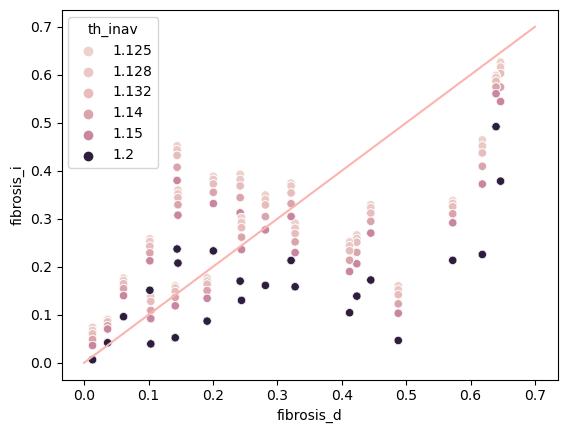

In [128]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df_pts, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=inav_thr_tested)
plt.plot(x,y)

<AxesSubplot:xlabel='perf_name', ylabel='performance'>

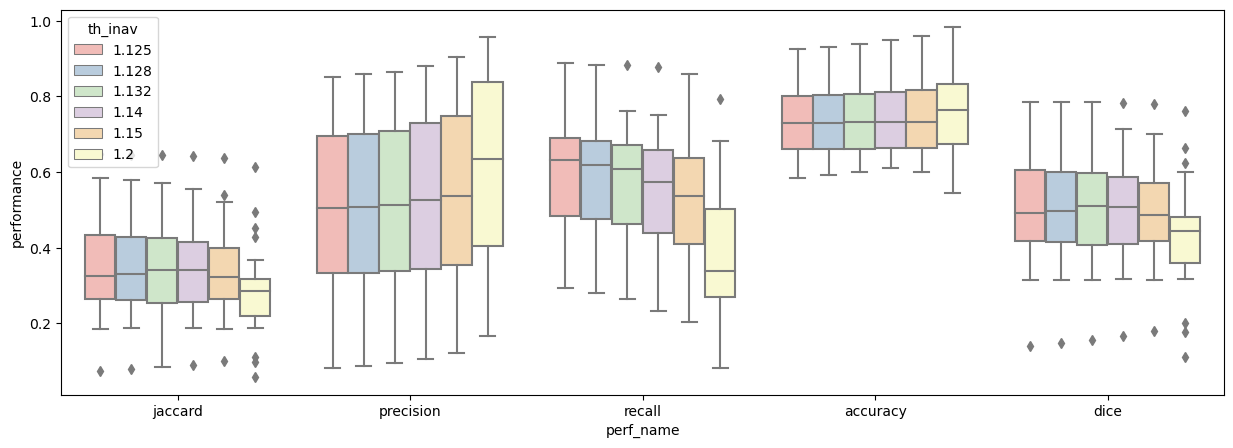

In [129]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df_pts,
            x='perf_name', y='performance', hue='th_inav', whis=1,
            hue_order=inav_thr_tested)

# plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [153]:
metric_name = 'dice'

print(metric_name)
for threshold in inav_thr_tested:
    # threshold = 1.1205
    metric = df_pts['performance']
    thresh = df_pts['th_inav']

    metric = metric[df_pts['perf_name'] == metric_name]
    thresh = thresh[df_pts['perf_name'] == metric_name]

    metric = metric[thresh == threshold]

    print('[{}]: {:.3f} (+/-{:.3f})'.format(threshold, np.mean(metric), np.std(metric)))
    print('{:.3f} ± {:.3f}'.format(np.mean(metric), np.std(metric)))



dice
[1.125]: 0.507 (+/-0.144)
[1.128]: 0.506 (+/-0.142)
[1.132]: 0.504 (+/-0.140)
[1.14]: 0.499 (+/-0.138)
[1.15]: 0.491 (+/-0.135)
[1.2]: 0.429 (+/-0.148)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


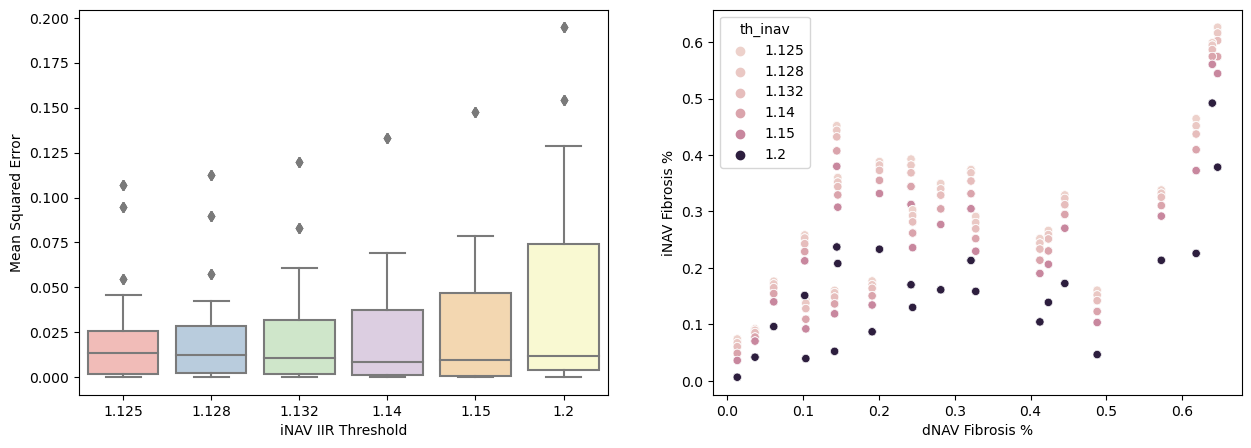

In [138]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')

sns.boxplot(ax=ax[0], x=df_pts['th_inav'], y=(df_pts['fibrosis_d']-df_pts['fibrosis_i'])
            ** 2, order=inav_thr_tested, 
            whis=1)
sns.scatterplot(ax=ax[1], data=df_pts, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=inav_thr_tested)
plt.plot()

ax[0].set_xlabel('iNAV IIR Threshold')
ax[0].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('dNAV Fibrosis %')
ax[1].set_ylabel('iNAV Fibrosis %')

plt.savefig(iou.fullfile(p2f, 'mean_sq_err_fibrosis_comp.eps'))

# sns.lmplot( data=df, x='fibrosis_d', y='fibrosis_i', col='th_inav', col_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

## Elemnt wise comparisons

In [145]:
iname_pts


'Scalars_i_on_d_pts.vtk'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


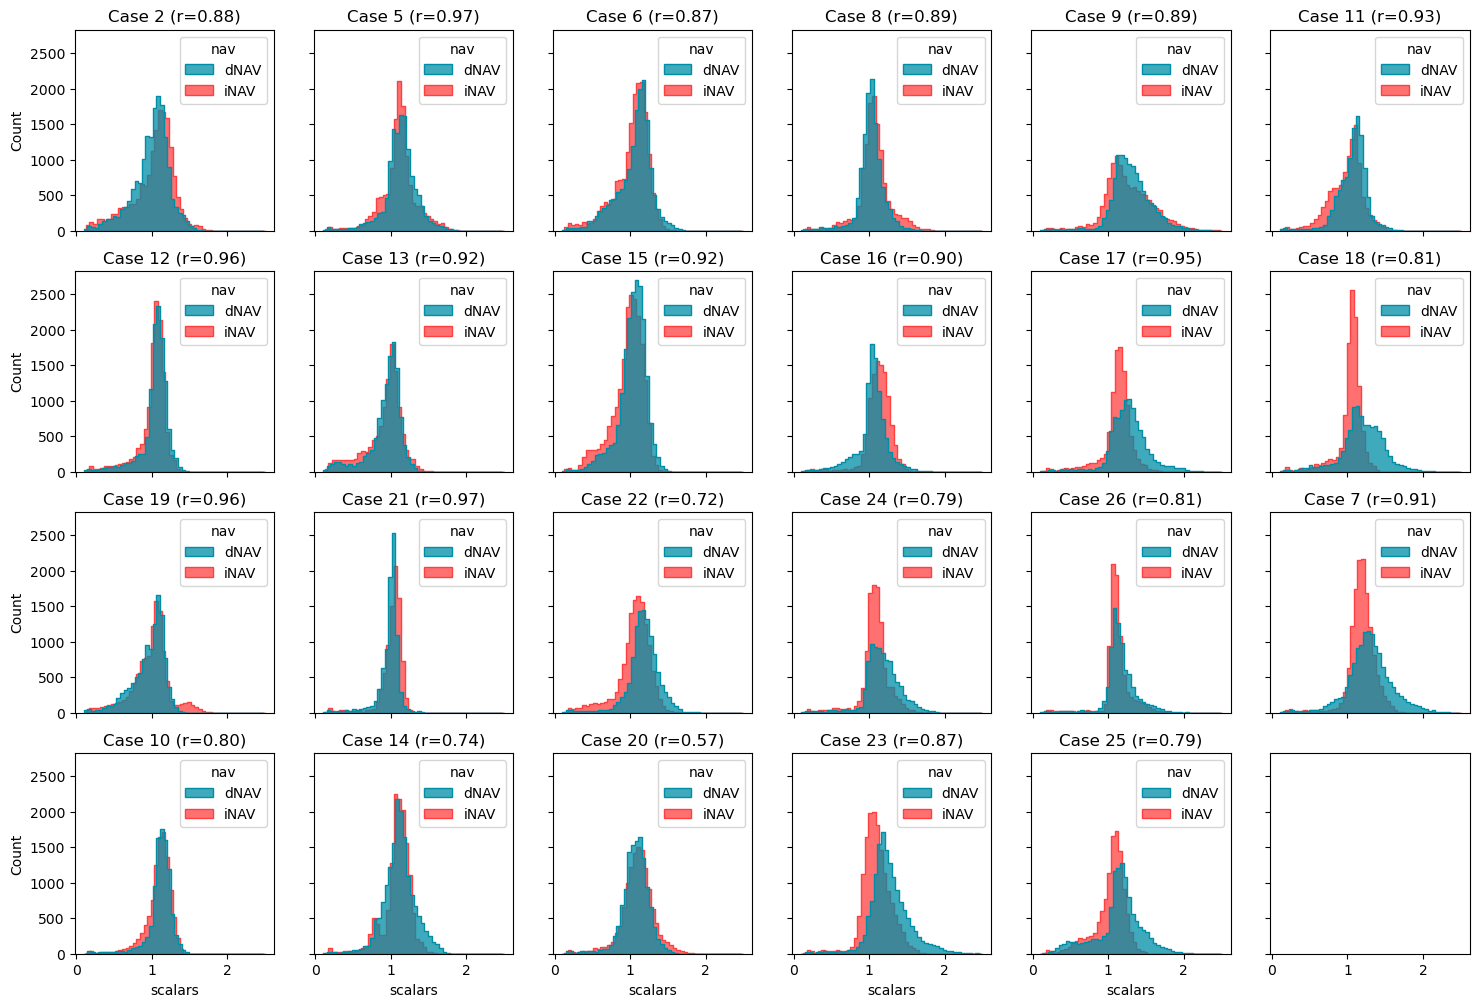

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstat

# cx = 0
fig, ax = plt.subplots(4, 6, sharex=True, sharey=True,squeeze=True)
fig.set_figwidth(18)
fig.set_figheight(12)

# Create an array with the colors you want to use
colors = ["#008ea7", "#ff4040"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# sns.set_palette('colorblind')

corrs = np.zeros(len(CX))

for cx in range(len(CX)) : 
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname), 'point')
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname_pts), 'point')

    df_test = pd.DataFrame({
        'scalars': ddat.tolist() + idat.tolist(), 
        'nav': ['dNAV'] * len(ddat) + ['iNAV']*len(idat)
        })

    subs = np.unravel_index(cx, (4,6))
    corrs[cx] = sstat.pearsonr(ddat, idat).statistic

    ax[subs].set_title('Case {} (r={:.2f})'.format(CX[cx], corrs[cx]))
    sns.histplot(ax=ax[subs], data=df_test, x='scalars', hue='nav', 
                element='step', bins=50, multiple='dodge', stat='count', 
                binrange=(0.1, 2.5))


plt.savefig(iou.fullfile(iou.fullfile(p2f, 'local', 'scalar_comparison_pts.eps')))



Ttest_1sampResult(statistic=1.9708537318244241, pvalue=0.06145083033773612)
0.022762270239384277


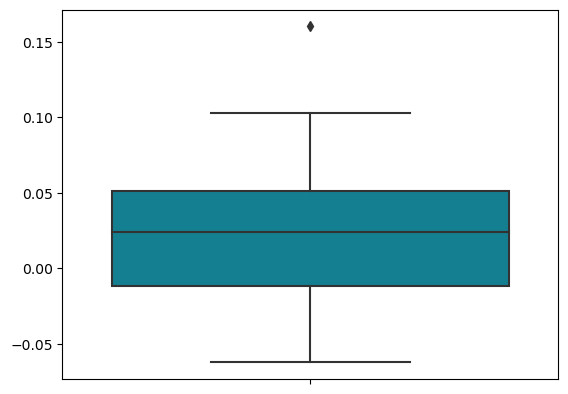

In [154]:
case_mean_diff = np.zeros(len(CX))
for cx in range(len(CX)):
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname), 'point')
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname_pts), 'point')

    case_mean_diff[cx] = np.mean(np.subtract(ddat, idat))


sns.boxplot(y=case_mean_diff)
print(sstat.ttest_1samp(a=case_mean_diff, popmean=0))
print(np.mean(case_mean_diff))

In [1]:
# import scipy.stats as sstat
# help(sstat.ttest_1samp)

def print_stats(arr) :
    print('{} +/- {}'.format(np.mean(arr), np.std(arr)))

print_stats(case_mean_diff)
print_stats(corrs)
print(iou.get_boxplot_values(corrs))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
print('')
# sns.histplot(x=case_mean_diff, bins=20)

NameError: name 'case_mean_diff' is not defined

In [37]:
def d_parse(dp2f) : 
    fd = open(dp2f, 'r')
    lines_d = fd.readlines()
    var = float(lines_d[-1].replace('SCORE: ', '').replace('\n', ''))
    fd.close()

    return var

In [40]:
def i_parse(ip2f) : 
    fi = open(ip2f, 'r')
    lines_i = fi.readlines()

    lines_i[0:3] = []
    lines_i_2 = [l.split(',') for l in lines_i]

    th = [float(x[0].replace('V=', '')) for x in lines_i_2]
    iscores = [float(x[1].replace('SCORE=', '')) for x in lines_i_2]
    fi.close()

    return th, iscores 

In [44]:
dsc = np.zeros((len(CX),1), dtype=float)
isc = {
    1.125 : np.zeros((len(CX), 1), dtype=float) , 
    1.128 : np.zeros((len(CX), 1), dtype=float) ,
    1.132 : np.zeros((len(CX), 1), dtype=float) ,
    1.14  : np.zeros((len(CX), 1), dtype=float) ,
    1.15  : np.zeros((len(CX), 1), dtype=float) ,
    1.2   : np.zeros((len(CX), 1), dtype=float)
    }

cx = 4
dp2f = iou.fullfile(p2f, 'local', CX[cx], xnav('d'),
                    'OUTPUT', 'prodThresholds.txt')
ip2f = iou.fullfile(p2f, 'local', CX[cx], xnav('i'),
                    'OUTPUT_final', 'IIR_MaxScar-single-voxel_prodStats.txt')

th, isc_aux = i_parse(ip2f)
dsc[cx] = d_parse(dp2f)

for ix in range(len(th)) : 
    isc[th[ix]][cx] = isc_aux[ix]




{1.125: array([[ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [43.9887],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ]]),
 1.128: array([[ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [43.9887],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ]]),
 1.132: array([[ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [43.9887],
      